# Pipe entrainement + score de confusion 

In [71]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import os

# Répertoire pour sauvegarder les modèles ONNX
onnx_dir = os.path.dirname(os.getcwd()) + "/models"
os.makedirs(onnx_dir, exist_ok=True)

# # Entraîner et sauvegarder chaque modèle
# for name, model in MODELS.items():
#     print(f"Training and saving model: {name}")
#     model.fit(X_train, y_train)  # Entraînement du modèle

#     # Conversion du modèle en ONNX
#     initial_type = [("float_input", FloatTensorType([None, X_train.shape[1]]))]
#     onnx_model = convert_sklearn(model, initial_types=initial_type)

#     # Sauvegarde du modèle ONNX
#     onnx_path = os.path.join(onnx_dir, f"{name}.onnx")
#     with open(onnx_path, "wb") as f:
#         f.write(onnx_model.SerializeToString())

#     print(f"Model {name} saved to {onnx_path}")

def save_model_onnx(name, model, path, initial_type):
    # initial_type = [("float_input", FloatTensorType([None, X_train.shape[1]]))]
    onnx_model = convert_sklearn(model, initial_types=initial_type)
    onnx_path = os.path.join(path, f"{name}.onnx")
    with open(onnx_path, "wb") as f:
        f.write(onnx_model.SerializeToString())
    print(f"Model {name} saved to {onnx_path}")

In [77]:
"""
walk_forward_example.py
-----------------------
Télécharge les prix (yfinance), crée un label binaire "UP +5 jours",
entraîne 4 modèles SK-Learn et affiche la matrice de confusion sur
un split chronologique 80 % / 20 %.
"""

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# ------------------------------------------------------------------
# 1. Paramètres généraux
# ------------------------------------------------------------------
TICKERS = ["AAPL", "MSFT", "GOOGL"]
LOOK_AHEAD = 5          # horizon de prédiction (jours)
TRAIN_RATIO = 0.80      # fraction chronologique pour le train-set
SEED = 42

# ------------------------------------------------------------------
# 2. Fonction utilitaire : features + label
# ------------------------------------------------------------------
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Label : prix dans 5 jours supérieur au prix courant ?
    df["future_close"] = df["Close"].shift(-LOOK_AHEAD)
    df["target"] = (df["future_close"] > df["Close"]).astype(int)

    # Features (exemples simples, extensibles) ────────────────
    df["ret1"]  = np.log(df["Close"] / df["Close"].shift(1))
    df["ret3"]  = np.log(df["Close"] / df["Close"].shift(3))
    df["sma5"]  = df["Close"].rolling(5).mean() / df["Close"] - 1
    df["vol5"]  = df["ret1"].rolling(5).std()

    df = df.dropna().reset_index(drop=True)  # retirer NaN
    return df[["Date", "target", "ret1", "ret3", "sma5", "vol5"]]

# ------------------------------------------------------------------
# 3. Modèles à tester
#    (la logistique bénéficie d’une standardisation automatique)
# ------------------------------------------------------------------
MODELS = {
    "Logistic": make_pipeline(StandardScaler(),
                              LogisticRegression(max_iter=1000, random_state=SEED)),
    "DecisionTree": DecisionTreeClassifier(random_state=SEED, max_depth=5),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=SEED, max_depth=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=SEED),
}

import os 
prepared_data_path  = os.path.dirname(os.getcwd()) + "/data/modelisation/prepared_data"
results_path        = os.path.dirname(os.getcwd()) + "/data/modelisation/results"
training_data_path  = os.path.dirname(os.getcwd()) + "/data/modelisation/training_data"
os.makedirs(prepared_data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(training_data_path, exist_ok=True)

# ------------------------------------------------------------------
# 4. Boucle principale par ticker
# ------------------------------------------------------------------
for tic in TICKERS:
    print(f"\n========================  {tic}  ========================\n")
    # 4-a. Télécharger et préparer
    price = yf.download(tic, start="2015-01-01", progress=False)
    price = price.reset_index()                # yfinance retourne DatetimeIndex
    price = price.droplevel(1, axis=1)  # supprimer le multi-index
    data  = prepare_data(price)

    # Save data to CSV for later use
    data.to_csv(f"{prepared_data_path}/{tic}_prepared.csv", index=False)
    X = data[["ret1", "ret3", "sma5", "vol5"]]
    y = data["target"].values
    
    # 4-b. Split chronologique
    cut = int(len(data) * TRAIN_RATIO)
    X_train, X_test = X.iloc[:cut], X.iloc[cut:]
    y_train, y_test = y[:cut], y[cut:]

    # Saving train and test data
    X_train.to_csv(f"{training_data_path}/{tic}_X_train.csv", index=False)
    X_test.to_csv(f"{training_data_path}/{tic}_X_test.csv", index=False)
    y_train = pd.DataFrame(y_train, columns=["target"])
    y_test = pd.DataFrame(y_test, columns=["target"])

    # 4-c. Entraînement + évaluation pour chaque modèle
    for name, model in MODELS.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        acc  = (tp + tn) / cm.sum()
        prec = tp / (tp + fp) if (tp + fp) else 0
        rec  = tp / (tp + fn) if (tp + fn) else 0
        f1   = 2 * prec * rec / (prec + rec) if (prec + rec) else 0

        print(f"--- {name} ---")
        print("Matrice de confusion\n", cm)
        print(f"Accuracy  : {acc:.3f}")
        print(f"Precision : {prec:.3f} | Recall : {rec:.3f} | F1 : {f1:.3f}\n")

        # save confusion matrix and score into json file 
        import json 
        with open(f"{results_path}/{tic}_{name}_results.json", "w") as f:
            json.dump({
                "confusion_matrix": cm.tolist(),
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1_score": f1
            }, f, indent=4)

        # Save model
        initial_type = [("float_input", FloatTensorType([None, X_train.shape[1]]))]
        save_model_onnx(name, model, onnx_dir, initial_type)


========================  AAPL  ========================



/Users/davidzhu/Local/gestion-quantitative/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/davidzhu/Local/gestion-quantitative/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



--- Logistic ---
Matrice de confusion
 [[  4 224]
 [  5 285]]
Accuracy  : 0.558
Precision : 0.560 | Recall : 0.983 | F1 : 0.713

Model Logistic saved to /Users/davidzhu/Local/gestion-quantitative/models/Logistic.onnx
--- DecisionTree ---
Matrice de confusion
 [[ 41 187]
 [ 45 245]]
Accuracy  : 0.552
Precision : 0.567 | Recall : 0.845 | F1 : 0.679

Model DecisionTree saved to /Users/davidzhu/Local/gestion-quantitative/models/DecisionTree.onnx
--- RandomForest ---
Matrice de confusion
 [[  8 220]
 [ 16 274]]
Accuracy  : 0.544
Precision : 0.555 | Recall : 0.945 | F1 : 0.699

Model RandomForest saved to /Users/davidzhu/Local/gestion-quantitative/models/RandomForest.onnx


/Users/davidzhu/Local/gestion-quantitative/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



--- GradientBoosting ---
Matrice de confusion
 [[ 24 204]
 [ 31 259]]
Accuracy  : 0.546
Precision : 0.559 | Recall : 0.893 | F1 : 0.688

Model GradientBoosting saved to /Users/davidzhu/Local/gestion-quantitative/models/GradientBoosting.onnx

========================  MSFT  ========================



/Users/davidzhu/Local/gestion-quantitative/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/davidzhu/Local/gestion-quantitative/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



--- Logistic ---
Matrice de confusion
 [[  1 223]
 [  2 292]]
Accuracy  : 0.566
Precision : 0.567 | Recall : 0.993 | F1 : 0.722

Model Logistic saved to /Users/davidzhu/Local/gestion-quantitative/models/Logistic.onnx
--- DecisionTree ---
Matrice de confusion
 [[ 37 187]
 [ 45 249]]
Accuracy  : 0.552
Precision : 0.571 | Recall : 0.847 | F1 : 0.682

Model DecisionTree saved to /Users/davidzhu/Local/gestion-quantitative/models/DecisionTree.onnx
--- RandomForest ---
Matrice de confusion
 [[  8 216]
 [ 22 272]]
Accuracy  : 0.541
Precision : 0.557 | Recall : 0.925 | F1 : 0.696

Model RandomForest saved to /Users/davidzhu/Local/gestion-quantitative/models/RandomForest.onnx


/Users/davidzhu/Local/gestion-quantitative/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



--- GradientBoosting ---
Matrice de confusion
 [[ 28 196]
 [ 40 254]]
Accuracy  : 0.544
Precision : 0.564 | Recall : 0.864 | F1 : 0.683

Model GradientBoosting saved to /Users/davidzhu/Local/gestion-quantitative/models/GradientBoosting.onnx

========================  GOOGL  ========================



/Users/davidzhu/Local/gestion-quantitative/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/davidzhu/Local/gestion-quantitative/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



--- Logistic ---
Matrice de confusion
 [[ 13 218]
 [  4 283]]
Accuracy  : 0.571
Precision : 0.565 | Recall : 0.986 | F1 : 0.718

Model Logistic saved to /Users/davidzhu/Local/gestion-quantitative/models/Logistic.onnx
--- DecisionTree ---
Matrice de confusion
 [[ 50 181]
 [ 64 223]]
Accuracy  : 0.527
Precision : 0.552 | Recall : 0.777 | F1 : 0.645

Model DecisionTree saved to /Users/davidzhu/Local/gestion-quantitative/models/DecisionTree.onnx
--- RandomForest ---
Matrice de confusion
 [[ 34 197]
 [ 28 259]]
Accuracy  : 0.566
Precision : 0.568 | Recall : 0.902 | F1 : 0.697

Model RandomForest saved to /Users/davidzhu/Local/gestion-quantitative/models/RandomForest.onnx


/Users/davidzhu/Local/gestion-quantitative/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



--- GradientBoosting ---
Matrice de confusion
 [[ 54 177]
 [ 59 228]]
Accuracy  : 0.544
Precision : 0.563 | Recall : 0.794 | F1 : 0.659

Model GradientBoosting saved to /Users/davidzhu/Local/gestion-quantitative/models/GradientBoosting.onnx


In [79]:
# Get the logistic regression model from the pipeline
logistic_model = MODELS["Logistic"]
scaler = logistic_model.named_steps['standardscaler']
lr = logistic_model.named_steps['logisticregression']

# Extract coefficients and intercept
coefficients = lr.coef_[0]  # Shape is (1, n_features)
intercept = lr.intercept_[0]
feature_names = X_train.columns

# Print formula with standardized features
print("Logistic Regression Formula (standardized features):")
formula_std = f"p(y=1) = 1 / (1 + exp(-({intercept:.4f}"
for i, (feature, coef) in enumerate(zip(feature_names, coefficients)):
    sign = "+" if coef > 0 else ""
    formula_std += f" {sign} {coef:.4f} * {feature}"
formula_std += ")))"
print(formula_std)

# Calculate formula with raw features (accounting for standardization)
means = scaler.mean_
stds = scaler.scale_

adjusted_intercept = intercept
for i, (mean, std, coef) in enumerate(zip(means, stds, coefficients)):
    adjusted_intercept -= coef * mean / std

adjusted_coefficients = [coef / std for coef, std in zip(coefficients, stds)]

print("\nLogistic Regression Formula (raw features):")
formula_raw = f"p(y=1) = 1 / (1 + exp(-({adjusted_intercept:.4f}"
for i, (feature, adj_coef) in enumerate(zip(feature_names, adjusted_coefficients)):
    sign = "+" if adj_coef > 0 else ""
    formula_raw += f" {sign} {adj_coef:.4f} * {feature}"
formula_raw += ")))"
print(formula_raw)

# Display feature importance (absolute magnitude of coefficients)
print("\nFeature Importance (standardized):")
importance = [(feature, abs(coef)) for feature, coef in zip(feature_names, coefficients)]
for feature, imp in sorted(importance, key=lambda x: x[1], reverse=True):
    print(f"{feature}: {imp:.4f}")

Logistic Regression Formula (standardized features):
p(y=1) = 1 / (1 + exp(-(0.2975 + 0.0929 * ret1 + 0.2094 * ret3 + 0.3864 * sma5  -0.0647 * vol5)))

Logistic Regression Formula (raw features):
p(y=1) = 1 / (1 + exp(-(0.3993 + 5.1585 * ret1 + 7.0016 * ret3 + 20.4597 * sma5  -6.4219 * vol5)))

Feature Importance (standardized):
sma5: 0.3864
ret3: 0.2094
ret1: 0.0929
vol5: 0.0647


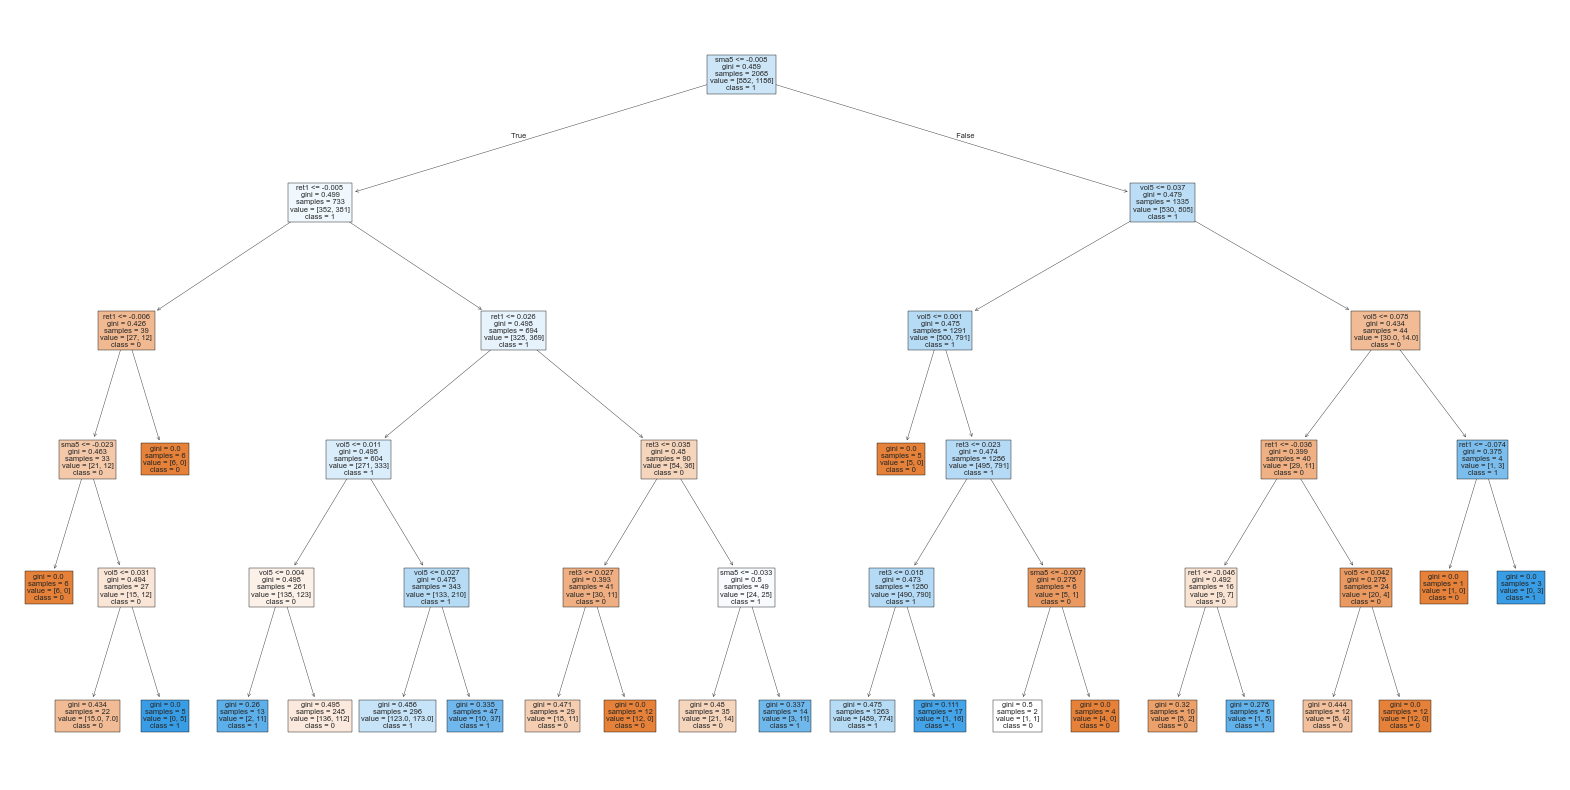

In [80]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

# Récupérer le modèle DecisionTreeClassifier
decision_tree_model = MODELS["DecisionTree"]

# Visualiser l'arbre de décision
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, feature_names=X_train.columns, class_names=["0", "1"], filled=True)
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# Visualisation du modèle Random Forest
import matplotlib.pyplot as plt

# Récupérer le modèle Random Forest
rf_model = MODELS["RandomForest"]

# Obtenir les prédictions et probabilités
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 1. Confusion Matrix Heatmap
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Baisse', 'Hausse'],
            yticklabels=['Baisse', 'Hausse'])
plt.ylabel('Valeur réelle')
plt.xlabel('Prédiction')
plt.title('Matrice de Confusion - Random Forest')

# 2. ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Random Forest')
plt.legend(loc="lower right")

# 3. Precision-Recall Curve
plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rf)
avg_precision = average_precision_score(y_test, y_pred_proba_rf)
plt.plot(recall, precision, color='green', lw=2, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall - Random Forest')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

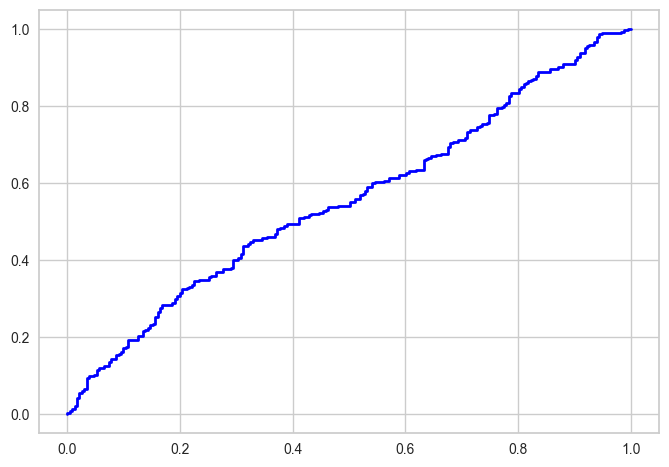

In [72]:
# plot la courbe ROC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

model = MODELS["Logistic"]
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))

In [65]:
# from interpret.glassbox import ExplainableBoostingClassifier
# from interpret import show

# # ------------------------------------------------------------------
# # 5. Interprétation du modèle
# #    (exemple avec la régression logistique)
# # ------------------------------------------------------------------

# # 5-a. Entraînement du modèle
# model = ExplainableBoostingClassifier()
# model.fit(X_train, y_train)

# show(model.explain_global())

In [66]:
# # local explanation 
# from interpret import show
# from interpret.glassbox import ExplainableBoostingClassifier

# show(model.explain_local(X_test, y_test))

# Pipe entrainement + saving + loading + inference

In [51]:
import onnxruntime as ort
import numpy as np

# # Load the ONNX model
# onnx_path = onnx_dir + "/Logistic.onnx"  # Change to the desired model
# onnx_session = ort.InferenceSession(onnx_path)

# # Prepare input data for inference
# # Assuming `X_test` is the input data for inference
# input_name = onnx_session.get_inputs()[0].name
# output_name = onnx_session.get_outputs()[0].name

# # Perform inference
# predictions = onnx_session.run([output_name], {input_name: X_test.to_numpy().astype(np.float32)})

# # Display predictions
# print("Predictions:", predictions[0])

def predict_onnx(model_path, X_test):
    # Load the ONNX model
    onnx_session = ort.InferenceSession(model_path)

    # Prepare input data for inference
    input_name = onnx_session.get_inputs()[0].name
    output_name = onnx_session.get_outputs()[0].name

    # Perform inference
    predictions = onnx_session.run([output_name], {input_name: X_test})

    return predictions[0]

X_test_subset = X_test.to_numpy().astype(np.float32)[0:5]
display(predict_onnx(onnx_dir + "/Logistic.onnx", X_test_subset))
display(predict_onnx(onnx_dir + "/RandomForest.onnx", X_test_subset))
display(predict_onnx(onnx_dir + "/GradientBoosting.onnx", X_test_subset))
display(predict_onnx(onnx_dir + "/DecisionTree.onnx", X_test_subset))

array([1, 1, 1, 1, 1], dtype=int64)

array([1, 1, 0, 1, 0], dtype=int64)

array([1, 1, 0, 1, 1], dtype=int64)

array([1, 0, 0, 0, 1], dtype=int64)

In [ ]:
X_test.to_numpy().astype(np.float32)[0:1]

array([[ 0.00355701, -0.03916762,  0.01769401,  0.01880945]],
      dtype=float32)

# Pipe étude influence

In [53]:
from yellowbrick.model_selection import FeatureImportances

# Exemple avec un modèle RandomForestClassifier
rf_model = MODELS["RandomForest"]  # Utiliser le modèle RandomForest déjà défini
rf_model.fit(X_train, y_train)  # Assurez-vous que le modèle est entraîné

# Visualisation de l'importance des caractéristiques
viz = FeatureImportances(rf_model.named_steps['randomforestclassifier'], labels=X_train.columns)
viz.fit(X_train, y_train)
viz.show()


AttributeError: 'RandomForestClassifier' object has no attribute 'named_steps'

In [4]:
# # Exemple simple d'utilisation de SHAP avec des données aléatoires
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.ensemble import RandomForestClassifier
# import shap

# # 1. Générer des données aléatoires
# np.random.seed(42)
# n_samples = 1000
# n_features = 5

# # Créer un DataFrame avec des features aléatoires
# feature_names = [f"feature_{i}" for i in range(n_features)]
# X = pd.DataFrame(np.random.randn(n_samples, n_features), columns=feature_names)

# # Créer une cible binaire qui dépend des features (avec du bruit)
# y = ((X['feature_0'] > 0) & (X['feature_1'] > 0)) | ((X['feature_2'] < -1) & (X['feature_3'] < 0))
# y = y.astype(int)

# # 2. Entraîner un modèle RandomForest
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X, y)

# # Évaluer la précision du modèle
# accuracy = model.score(X, y)
# print(f"Précision du modèle: {accuracy:.4f}")

# # 3. Utiliser SHAP pour expliquer le modèle
# # Créer un explainer pour les modèles à base d'arbres
# explainer = shap.TreeExplainer(model)

# # Calculer les valeurs SHAP pour un sous-ensemble de données
# shap_values = explainer.shap_values(X.iloc[:100])

# # 4. Visualisation des explications SHAP

# # # Résumé des importances des features (plot de type bar)
# # plt.figure(figsize=(10, 6))
# # shap.summary_plot(shap_values[1], X.iloc[:100], plot_type="bar", show=False)
# # plt.title("Importance globale des features")
# # plt.tight_layout()
# # plt.show()

# # # Visualisation des effets détaillés (SHAP summary plot)
# # plt.figure(figsize=(10, 6))
# # shap.summary_plot(shap_values[1], X.iloc[:100], show=False)
# # plt.title("Effet des valeurs des features sur les prédictions")
# # plt.tight_layout()
# # plt.show()

# # # Tracé de dépendance pour la feature la plus importante
# # plt.figure(figsize=(10, 6))
# # feature_idx = np.argmax([np.abs(shap_values[1][:, i].mean()) for i in range(n_features)])
# # shap.dependence_plot(feature_idx, shap_values[1], X.iloc[:100], show=False)
# # plt.title(f"Graphique de dépendance pour {feature_names[feature_idx]}")
# # plt.tight_layout()
# # plt.show()

# # # Force plot pour une instance spécifique
# # plt.figure(figsize=(16, 3))
# # shap.initjs()  # Initialise JavaScript pour les visualisations interactives
# # instance_idx = 0
# # shap.force_plot(explainer.expected_value[1], 
# #                 shap_values[1][instance_idx], 
# #                 X.iloc[instance_idx],
# #                 matplotlib=True,
# #                 show=False)
# # plt.title("Force plot pour une prédiction spécifique")
# # plt.tight_layout()
# # plt.show()

# # print("Les valeurs positives en rouge poussent la prédiction vers 1")
# # print("Les valeurs négatives en bleu poussent la prédiction vers 0")